<a href="https://www.kaggle.com/aaroha33/text-summarization-attention-mechanism?scriptVersionId=84249930" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<font size="+5" color=Green > <b> <center><u>
    <br>Text Summarization 
    <br>Sequenece to Sequence Modelling
    <br>Attention Mechanism

# Import Libraries

In [31]:
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Parse the Data

We’ll take a sample of 100,000 reviews to reduce the training time of our model.

In [32]:
#read the dataset file for text Summarizer
df=pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv",nrows=10000)
# df = pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv")
#drop the duplicate and na values from the records
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True) #dropping na
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']
target_data.replace('', np.nan, inplace=True)

In [33]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9513 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      9513 non-null   int64 
 1   ProductId               9513 non-null   object
 2   UserId                  9513 non-null   object
 3   ProfileName             9513 non-null   object
 4   HelpfulnessNumerator    9513 non-null   int64 
 5   HelpfulnessDenominator  9513 non-null   int64 
 6   Score                   9513 non-null   int64 
 7   Time                    9513 non-null   int64 
 8   Summary                 9513 non-null   object
 9   Text                    9513 non-null   object
dtypes: int64(5), object(5)
memory usage: 817.5+ KB


In [34]:
df['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [35]:
df['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

# Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [36]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We can use the contraction using two method, one we can use the above dictionary or we can keep the contraction file as a data set and import it. 

In [37]:
input_texts=[]  # Text column
target_texts=[] # summary column
input_words=[]
target_words=[]
# contractions=pickle.load(open("../input/contraction/contractions.pkl","rb"))['contractions']
contractions = contraction_mapping

#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

# Data Cleaning

In [38]:
def clean(texts,src):
  texts = BeautifulSoup(texts, "lxml").text   #remove the html tags
  words=word_tokenize(texts.lower())  #tokenize the text into words 
  #filter words which contains \ 
  #integers or their length is less than or equal to 3
  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #contraction file to expand shortened words
  words= [contractions[w] if w in contractions else w for w in words ]

  #stem the words to their root word and filter stop words
  if src=="inputs":
    words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

In [39]:
#pass the input records and target records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

In [40]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  10344
number of target words :  4169
maximum input length :  73
maximum target length :  17


# Split it

In [42]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0) 

In [43]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [44]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')
 
#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

# Model Building

In [45]:
K.clear_session() 
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

2022-01-02 15:47:58.428125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 15:47:58.520637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 15:47:58.521453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 15:47:58.522664: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [46]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

In [47]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

# Decoder

In [48]:
# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

# Attention Layer

In [49]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [50]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge)

# Train the Model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 73)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 73, 500)      5172500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 73, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

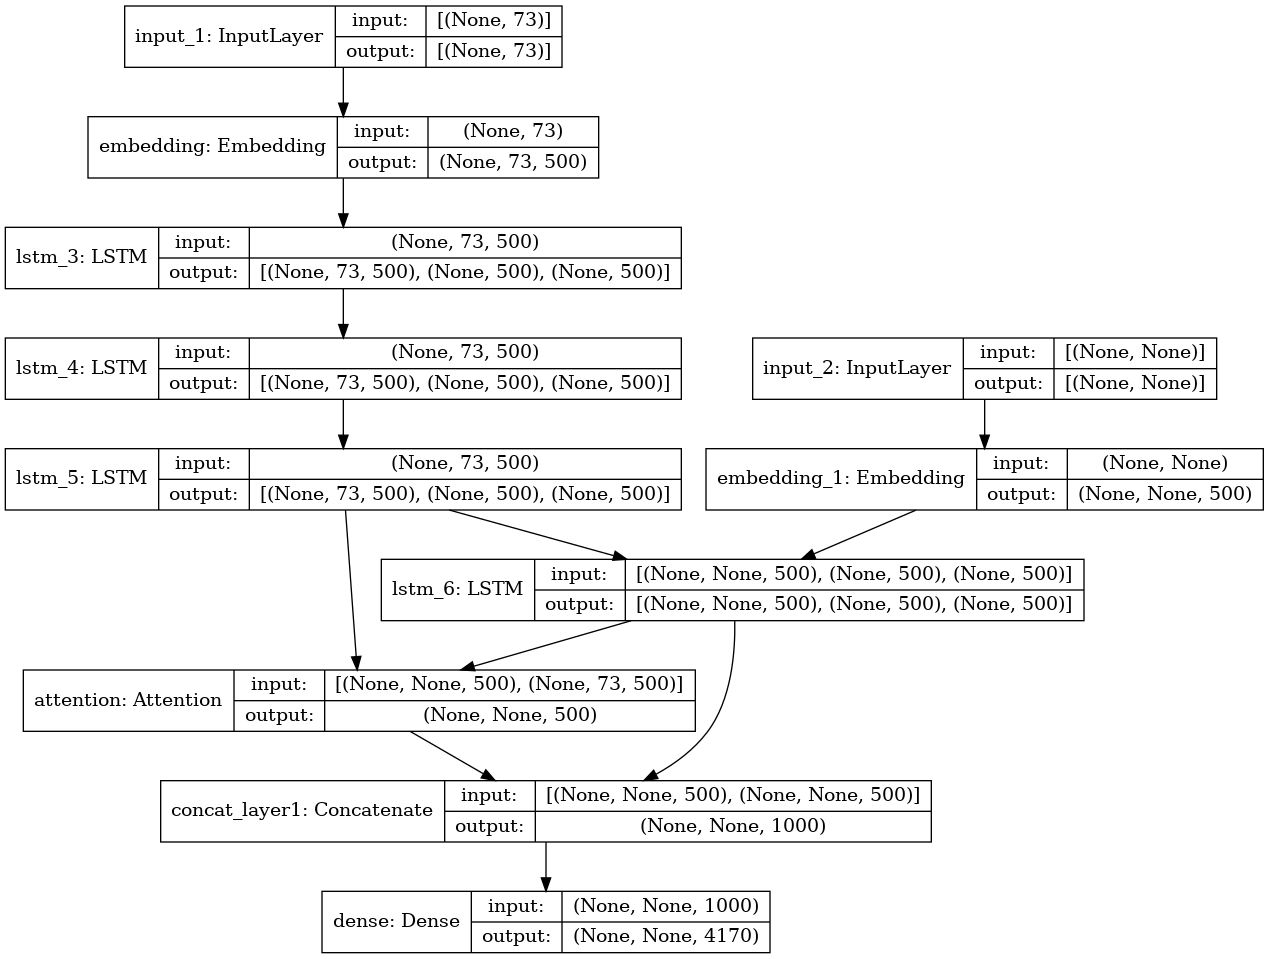

In [51]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [55]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
history = model.fit( 
                    [en_in_data, dec_in_data],
                    dec_tr_data, 
                    batch_size=512, 
                    epochs=10, 
                    validation_split=0.1,)

Epoch 1/10


2022-01-02 15:55:53.786890: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16152002560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


14/14 [==============================] - ETA: 0s - loss: 1.1584 - accuracy: 0.8356

2022-01-02 15:55:58.945076: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16152002560 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


14/14 [==============================] - 10s 369ms/step - loss: 1.1584 - accuracy: 0.8356 - val_loss: 1.2886 - val_accuracy: 0.8351
Epoch 2/10
14/14 [==============================] - 4s 291ms/step - loss: 1.0995 - accuracy: 0.8373 - val_loss: 1.2822 - val_accuracy: 0.8377
Epoch 3/10
14/14 [==============================] - 4s 291ms/step - loss: 1.0717 - accuracy: 0.8379 - val_loss: 1.2928 - val_accuracy: 0.8371
Epoch 4/10
14/14 [==============================] - 4s 295ms/step - loss: 1.0585 - accuracy: 0.8378 - val_loss: 1.2998 - val_accuracy: 0.8375
Epoch 5/10
14/14 [==============================] - 4s 291ms/step - loss: 1.0241 - accuracy: 0.8389 - val_loss: 1.3025 - val_accuracy: 0.8376
Epoch 6/10
14/14 [==============================] - 4s 291ms/step - loss: 1.0020 - accuracy: 0.8397 - val_loss: 1.3192 - val_accuracy: 0.8373
Epoch 7/10
14/14 [==============================] - 4s 291ms/step - loss: 0.9805 - accuracy: 0.8402 - val_loss: 1.3211 - val_accuracy: 0.8379
Epoch 8/10
14/14

In [53]:
# save model
model.save('Text_Summarizer.h5')
print('Model Saved!')

Model Saved!


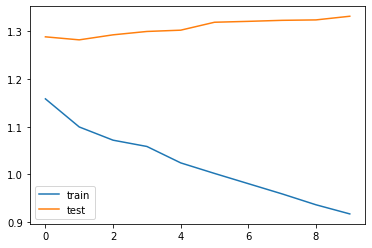

In [56]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

# Inference Model

### Encoder Inference:

In [59]:
# encoder inference
latent_dim=500
#/content/gdrive/MyDrive/Text Summarizer/
#load the model
model = models.load_model("Text_Summarizer.h5")
 
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

### Decoder Inference:

In [60]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

### Attention Inference:

In [61]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

### Dense layer

In [81]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [86]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index

In [97]:
def decode_sequence(input_seq):
    # get the encoder output and states by passing the input sequence
    en_out, en_h, en_c = en_model.predict(input_seq)

    # target sequence with inital word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']

    # if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    # append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition:
        # get predicted output, hidden and cell state.
        output_words, dec_h, dec_c = dec_model.predict([target_seq] + [en_out, en_h, en_c])

        # get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word + " "

        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
            stop_condition = True

        # update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c

    # return the deocded sentence
    return decoded_sentence

In [99]:
inp_review = input("Enter : ")
print("Review :", inp_review)

inp_review = clean(inp_review, "inputs")
inp_review = ' '.join(inp_review)
inp_x = in_tokenizer.texts_to_sequences([inp_review])
inp_x = pad_sequences(inp_x, maxlen=max_in_len, padding='post')

summary = decode_sequence(inp_x.reshape(1, max_in_len))
if 'eos' in summary:
    summary = summary.replace('eos', '')
print("\nPredicted summary:", summary);
print("\n")

Enter :  Seventy-Six is a historical fiction novel by American writer John Neal (pictured). Published in Baltimore in 1823, it is the fourth novel written about the American Revolutionary War. Historically distinguished for its pioneering use of colloquial language, the Yankee dialect, battle scene realism, high characterization, stream of consciousness narrative, profanity, and depictions of sex and romance, the novel foreshadowed and influenced later American fiction. With narrative prose that resembles spoken American English more than any other period literature, it was the first work of American fiction to use the phrase son-of-a-bitch. It explores male pain and self-loathing resulting from violent acts committed in war and duels. Inspired by his own historical research, Neal took only twenty-seven days to write the 528-page novel, reporting that "I tumbled out of my chair" because "I had fainted, – swooned, – from overwork."


Review : Seventy-Six is a historical fiction novel by American writer John Neal (pictured). Published in Baltimore in 1823, it is the fourth novel written about the American Revolutionary War. Historically distinguished for its pioneering use of colloquial language, the Yankee dialect, battle scene realism, high characterization, stream of consciousness narrative, profanity, and depictions of sex and romance, the novel foreshadowed and influenced later American fiction. With narrative prose that resembles spoken American English more than any other period literature, it was the first work of American fiction to use the phrase son-of-a-bitch. It explores male pain and self-loathing resulting from violent acts committed in war and duels. Inspired by his own historical research, Neal took only twenty-seven days to write the 528-page novel, reporting that "I tumbled out of my chair" because "I had fainted, – swooned, – from overwork."

Predicted summary: great product  


